# Wine Quality:
<hr style="border:2px solid black">

## Goal: 
* 
* 
<hr style="border:2px solid black">

# Imports

In [1]:
# Standard ds imports:
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Statisitics
from scipy import stats

import os
import acquire as a
import wrangle as wr

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

<hr style="border:2px solid black">

# **Acquire**
Plan --> **Acquire** --> Prepare --> Explore --> Model --> Deliver

In [2]:
# Acquire
df = a.acquire_wine()

In [3]:
df.is_red.value_counts()

is_red
0    4898
1    1599
Name: count, dtype: int64

<hr style="border:2px solid black">

# **Prepare**

In [4]:
df = wr.remove_outliers(df, exclude_cols=['quality','is_red'])

In [5]:
df.is_red.value_counts()

is_red
0    4336
1     688
Name: count, dtype: int64

In [764]:
# split into train, validate, test
train, validate, test = wr.splitter(df, stratify='quality')

Dataframe: (6497, 13) 100%
Train: (4157, 13) | ~60%
Validate: (1040, 13) | ~20%
Test: (1300, 13) | ~20%


In [765]:
train_scaled_added, validate_scaled_added, test_scaled_added = wr.QuickScale_2(train, validate, test, linear=True, scaler='Standard', exclude_cols= ['is_red', 'quality'])

In [766]:
train = train_scaled_added.drop(columns=['fixed_acidity_scaled', 'volatile_acidity_scaled', 'citric_acid_scaled',
       'residual_sugar_scaled', 'chlorides_scaled',
       'free_sulfur_dioxide_scaled', 'total_sulfur_dioxide_scaled',
       'density_scaled', 'ph_scaled', 'sulphates_scaled', 'alcohol_scaled'])

train_scaled = train_scaled_added.drop(columns=['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol'])

validate = validate_scaled_added.drop(columns=['fixed_acidity_scaled', 'volatile_acidity_scaled', 'citric_acid_scaled',
       'residual_sugar_scaled', 'chlorides_scaled',
       'free_sulfur_dioxide_scaled', 'total_sulfur_dioxide_scaled',
       'density_scaled', 'ph_scaled', 'sulphates_scaled', 'alcohol_scaled'])

validate_scaled = validate_scaled_added.drop(columns=['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol'])

test = test_scaled_added.drop(columns=['fixed_acidity_scaled', 'volatile_acidity_scaled', 'citric_acid_scaled',
       'residual_sugar_scaled', 'chlorides_scaled',
       'free_sulfur_dioxide_scaled', 'total_sulfur_dioxide_scaled',
       'density_scaled', 'ph_scaled', 'sulphates_scaled', 'alcohol_scaled'])

test_scaled = test_scaled_added.drop(columns=['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol'])

In [767]:
train_scaled.columns

Index(['quality', 'is_red', 'fixed_acidity_scaled', 'volatile_acidity_scaled',
       'citric_acid_scaled', 'residual_sugar_scaled', 'chlorides_scaled',
       'free_sulfur_dioxide_scaled', 'total_sulfur_dioxide_scaled',
       'density_scaled', 'ph_scaled', 'sulphates_scaled', 'alcohol_scaled'],
      dtype='object')

<hr style="border:2px solid black">

# **Explore**
Plan --> Acquire --> Prepare --> **Explore** --> Model --> Deliver

In [770]:
cat_cols, num_cols = wr.organize_columns(train)

In [771]:
# wr.check_cat_distribution(df)

## Bivariate Analysis

In [772]:
train.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol', 'quality', 'is_red'],
      dtype='object')

In [773]:
# for col in train[num_cols]:
#    sns.swarmplot(data=train.sample(1000), y=df[col], x='quality')
#    t = col.lower()
#    plt.title(t)
#    plt.show()

>

> ### Takeaways:
>
> #### Relationships to target:
> - fixed_acidity: looks to have a negative correlation with quality
> - volatile_acidity: looks to have a strong negative correlation with quality
> - citric_acid: doesn't seem to have a linear correlation, there may be a signal revealed after clustering
> - chlorides: possibly a negative corelation with quality
> - free_sulfur_dioxide: relationship unclear
> - total_sulfur_dioxide: possible positive correlation
> - density: Pretty clear negative correlation
> - ph: Not a clear relationship
> - sulphates: Not a clear relationship
> - alcohol: Positive linear correlation
>
> Best features:
> * fixed_acidity: negative
> * volatile_acidity: strong negative
> * density: negative
> * alcohol: positive
>
> Not sure, lets do hypothesis testing:
> * chlorides
> * total_sulfur_dioxide
>
> Signal Unclear, let's cluster these:
> * citric_acid
> * ph
> * sulphates

## Multivariate Analysis

In [774]:
sns.scatterplot(data=train, x='sulphates', y='citric_acid', hue='quality', palette='coolwarm')

> citric_acid: Looks like there is something happening below about 0.25 and above about 0.5. Good candidate for clustering

In [775]:
sns.scatterplot(data=train, x='sulphates', y='total_sulfur_dioxide', hue='quality', palette='coolwarm')

> 

> total_sulfur_dioxide: Looks like there is something happening below about 75 and above about 150. Good candidate for clustering.

In [776]:
sns.scatterplot(data=train, x='sulphates', y='volatile_acidity', hue='quality', palette='coolwarm')

> sulphates: Maybe some signal below 0.50?

In [777]:
sns.scatterplot(data=train.sample(1000), x='sulphates', y='total_sulfur_dioxide', hue='quality', palette='coolwarm')

### Q1. Is there a relationship between fixed_acidity and quality?
<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

Assumptions:
Normality: both quality and fixed_acidity have relatively normal distribution.


**I will now use a Spearman correlation to check for a monotonic relationship betwen fixed_acidity and quality.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: There is no ordinal correlation between fixed_acidity and quality.**<br>
**Ha: There is an ordinal correlation between fixed_acidity and quality.**
</div>

In [778]:
# set alpha
alpha = 0.05

r, p = stats.spearmanr(train.fixed_acidity, train.quality)

if p < alpha:
    print('We can reject our null hypothesis and suggest that there is a relationship between fixed_acidity and quality.')
    print(r, p)
else:
    print('We fail to reject the null hypothesis')
    print(r, p)


We can reject our null hypothesis and suggest that there is a relationship between fixed_acidity and quality.
-0.10158339416874636 5.217750741281213e-11


### Q2. Is there a relationship between chlorides and quality?

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

Assumptions:
Normality: both quality and chlorides have relatively normal distribution.


**I will now use a Spearman correlation to check for a monotonic relationship betwen chlorides and quality.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: There is no ordinal correlation between chlorides and quality.**<br>
**Ha: There is an ordinal correlation between chlorides and quality.**
</div>

In [779]:
r, p = stats.spearmanr(train.chlorides, train.quality)

if p < alpha:
    print('We can reject our null hypothesis and suggest that there is a relationship between chlorides and quality.')
    print(r, p)
else:
    print('We fail to reject the null hypothesis')
    print(r, p)

We can reject our null hypothesis and suggest that there is a relationship between chlorides and quality.
-0.30451919102860586 6.36435669486711e-90


### Q3. Is there a relationship between total_sulfur_dioxide and quality?

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

Assumptions:
Normality: both quality and total_sulfur_dioxide have relatively normal distribution.


**I will now use a Spearman correlation to check for a monotonic relationship between total_sulfur_dioxide and quality.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: There is no ordinal correlation between total_sulfur_dioxide and quality.**<br>
**Ha: There is an ordinal correlation between total_sulfur_dioxide and quality.**
</div>

In [780]:
r, p = stats.spearmanr(train.total_sulfur_dioxide, train.quality)

if p < alpha:
    print('We can reject our null hypothesis and suggest that there is a relationship between total_sulfur_dioxide and quality.')
    print(r, p)
else:
    print('We fail to reject the null hypothesis')
    print(r, p)

We can reject our null hypothesis and suggest that there is a relationship between total_sulfur_dioxide and quality.
-0.03761888506073406 0.015283136547943535


## Clustering
> * citric_acid, total_sulfur_dioxide, sulphates

In [781]:
x_val_scaled

,is_red,fixed_acidity_scaled,volatile_acidity_scaled,citric_acid_scaled,residual_sugar_scaled,chlorides_scaled,free_sulfur_dioxide_scaled,total_sulfur_dioxide_scaled,density_scaled,ph_scaled,sulphates_scaled,alcohol_scaled,clusters_1,clusters_2,clusters_3,clusters_4
878,0,-0.798131,-1.091954,1.487300,-0.854687,1.959193,0.384975,-0.085011,-0.524179,0.071228,-1.087234,-1.324979,0,3,1,2
5717,1,1.416683,1.900400,-1.145879,-0.472983,1.140879,-1.212116,-0.979316,1.692463,0.379530,0.035623,-0.737533,3,0,5,1
3760,0,0.423835,-0.852565,0.001917,-0.091279,-1.144755,0.042741,-0.242830,-0.976969,-1.408622,-0.955134,0.437360,1,1,0,2
3318,0,-0.492639,-1.091954,0.204469,-0.769864,-0.411095,-0.242453,-0.172688,-1.733871,-0.175414,1.422682,1.612252,2,2,2,2
5369,1,1.798547,1.182235,0.677091,-0.642629,0.689396,-0.299492,-1.102064,0.759851,-0.113754,1.158481,0.773043,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,0,0.041971,-0.194247,2.500061,1.011422,-0.439313,1.582794,0.791759,0.996383,-0.976999,-0.558831,-1.576742,0,3,1,0
3039,0,-0.721758,-0.433636,-0.200636,1.435538,-0.354659,1.639833,1.423033,1.036931,-0.483716,-0.889083,-1.408900,0,3,1,0
3242,0,-0.187148,-0.313942,0.204469,-0.854687,-0.580401,0.670170,-0.102546,-1.203364,0.564511,0.564027,0.940885,1,1,4,2
3405,0,-1.103622,-1.151801,0.001917,-0.897099,-0.552183,-0.926921,0.072808,-1.142541,-0.175414,-0.228579,-0.234008,1,1,0,2


In [782]:
cluster_features_1 = train_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled']]
cluster_features_1_val = validate_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled']]
cluster_features_1_test = test_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled']]


cluster_features_2 = train_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled', 'chlorides_scaled']]
cluster_features_2_val = validate_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled', 'chlorides_scaled']]
cluster_features_2_test = test_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled', 'chlorides_scaled']]


cluster_features_3 = train_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled', 'chlorides_scaled', 'ph_scaled']]
cluster_features_3_val = validate_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled', 'chlorides_scaled', 'ph_scaled']]
cluster_features_3_test = test_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled', 'chlorides_scaled', 'ph_scaled']]


cluster_features_4 = train_scaled.drop(columns=['quality'])
cluster_features_4_val = validate_scaled.drop(columns=['quality'])
cluster_features_4_test = test_scaled.drop(columns=['quality'])

### KMeans

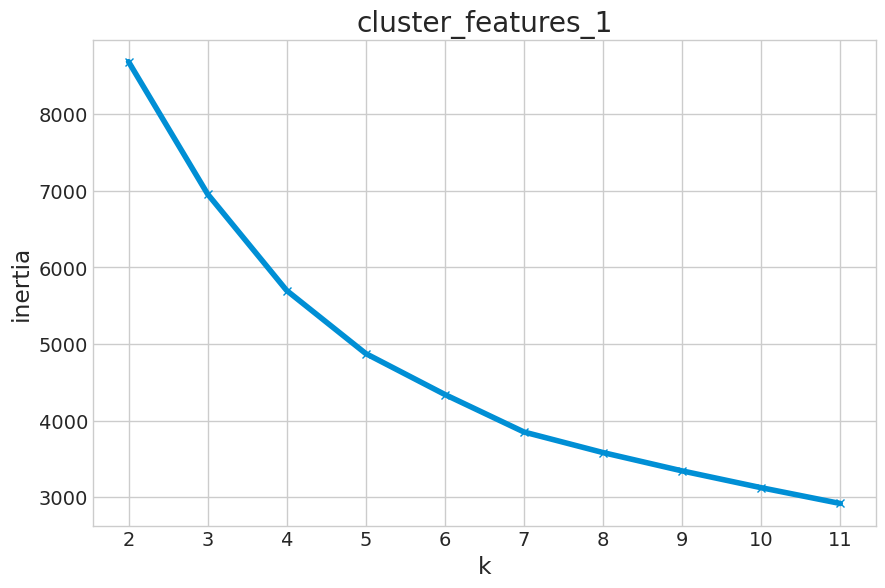

In [783]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9,6))
    pd.Series({k: KMeans(k).fit(cluster_features_1).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.title('cluster_features_1')
    plt.ylabel('inertia')

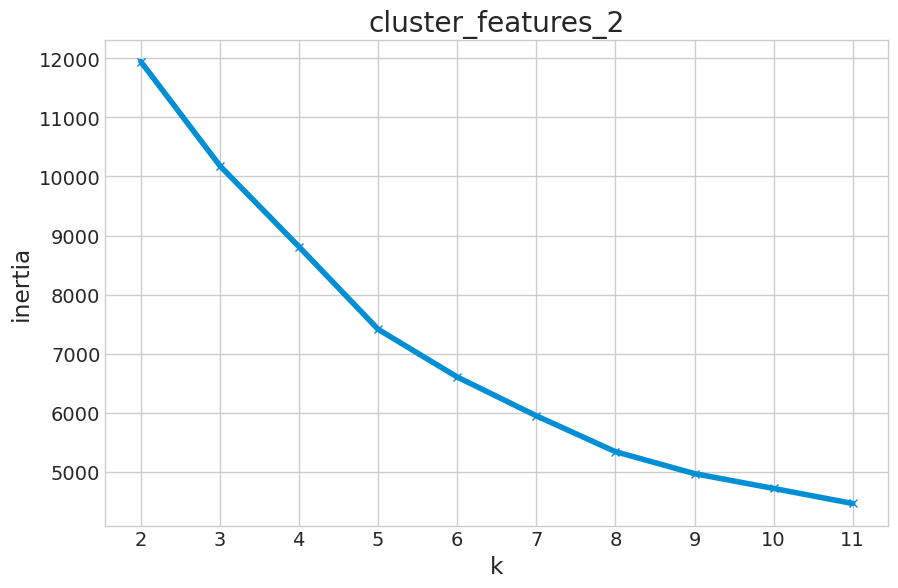

In [784]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9,6))
    pd.Series({k: KMeans(k).fit(cluster_features_2).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.title('cluster_features_2')
    plt.ylabel('inertia')

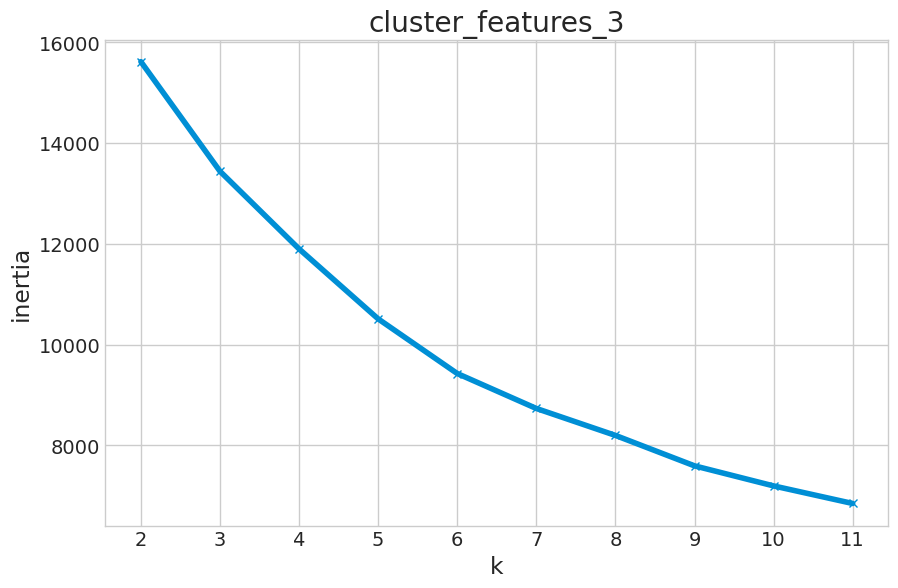

In [785]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9,6))
    pd.Series({k: KMeans(k).fit(cluster_features_3).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.title('cluster_features_3')
    plt.ylabel('inertia')

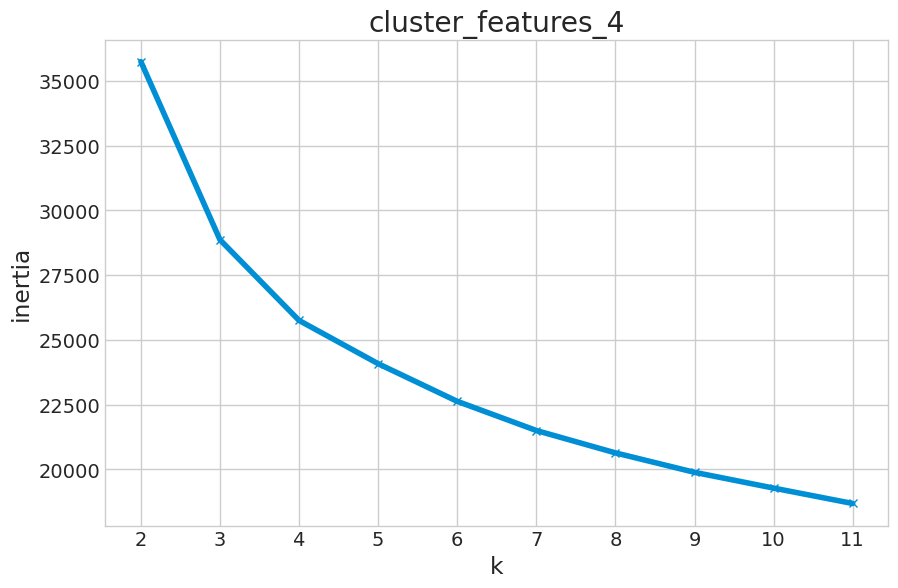

In [786]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9,6))
    pd.Series({k: KMeans(k).fit(cluster_features_4).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.title('cluster_features_4')
    plt.ylabel('inertia')

> cluster_features_1: k=4 \
> cluster_features_2: k=5 \
> cluster_features_3: k=6 \
> cluster_features_4: k=3

In [787]:
kmeans_1 = KMeans(n_clusters=4)
kmeans_2 = KMeans(n_clusters=5)
kmeans_3 = KMeans(n_clusters=6)
kmeans_4 = KMeans(n_clusters=3)

kmeans_1.fit(cluster_features_1)
kmeans_2.fit(cluster_features_2)
kmeans_3.fit(cluster_features_3)
kmeans_4.fit(cluster_features_4)

# Predict on train
clusters_1_train = kmeans_1.predict(cluster_features_1)
clusters_2_train = kmeans_2.predict(cluster_features_2)
clusters_3_train = kmeans_3.predict(cluster_features_3)
clusters_4_train = kmeans_4.predict(cluster_features_4)

# Predict on Val
clusters_1_val = kmeans_1.predict(cluster_features_1_val)
clusters_2_val = kmeans_2.predict(cluster_features_2_val)
clusters_3_val = kmeans_3.predict(cluster_features_3_val)
clusters_4_val = kmeans_4.predict(cluster_features_4_val)

# Add predictions to dataframes
train_scaled['clusters_1'] = clusters_1_train
train_scaled['clusters_2'] = clusters_2_train
train_scaled['clusters_3'] = clusters_3_train
train_scaled['clusters_4'] = clusters_4_train

validate_scaled['clusters_1'] = clusters_1_val
validate_scaled['clusters_2'] = clusters_2_val
validate_scaled['clusters_3'] = clusters_3_val
validate_scaled['clusters_4'] = clusters_4_val


In [788]:
train_scaled.columns

Index(['quality', 'is_red', 'fixed_acidity_scaled', 'volatile_acidity_scaled',
       'citric_acid_scaled', 'residual_sugar_scaled', 'chlorides_scaled',
       'free_sulfur_dioxide_scaled', 'total_sulfur_dioxide_scaled',
       'density_scaled', 'ph_scaled', 'sulphates_scaled', 'alcohol_scaled',
       'clusters_1', 'clusters_2', 'clusters_3', 'clusters_4'],
      dtype='object')

Text(0.5, 1.0, 'Cluster Model 1')

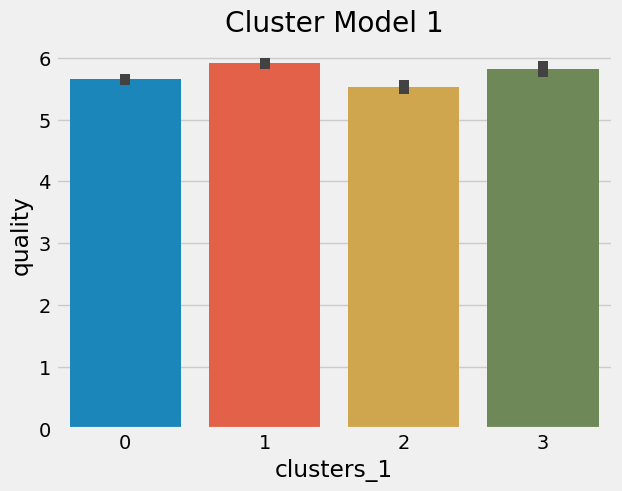

In [789]:
sns.barplot(data=train_scaled.sample(1000), y='quality', x='clusters_1')
plt.title('Cluster Model 1')

Text(0.5, 1.0, 'Cluster Model 2')

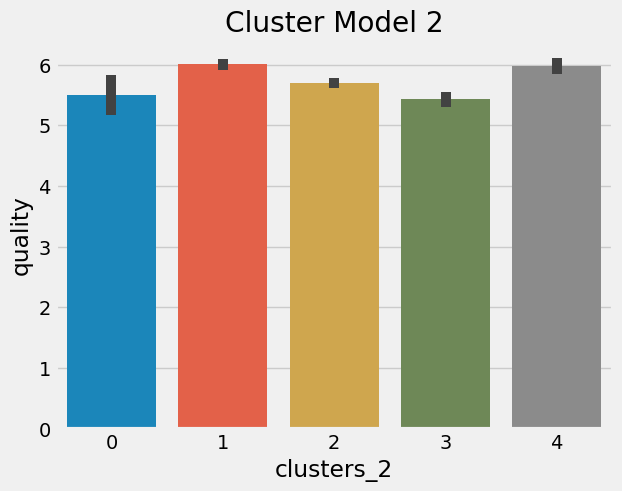

In [790]:
sns.barplot(data=train_scaled.sample(1000), y='quality', x='clusters_2')
plt.title('Cluster Model 2')

Text(0.5, 1.0, 'Cluster Model 3')

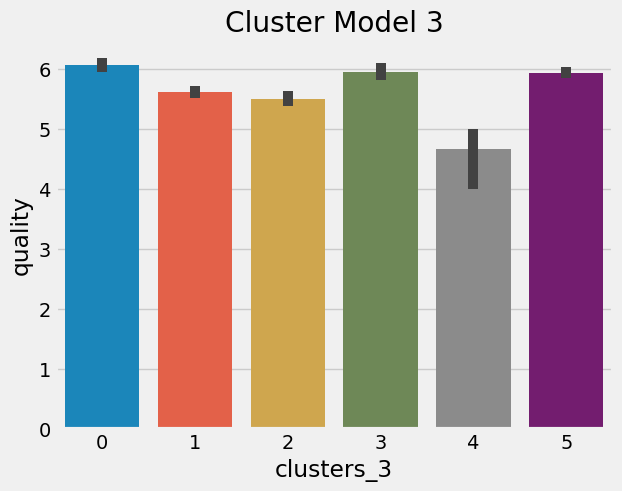

In [791]:
sns.barplot(data=train_scaled.sample(1000), y='quality', x='clusters_3')
plt.title('Cluster Model 3')

Text(0.5, 1.0, 'Cluster Model 4')

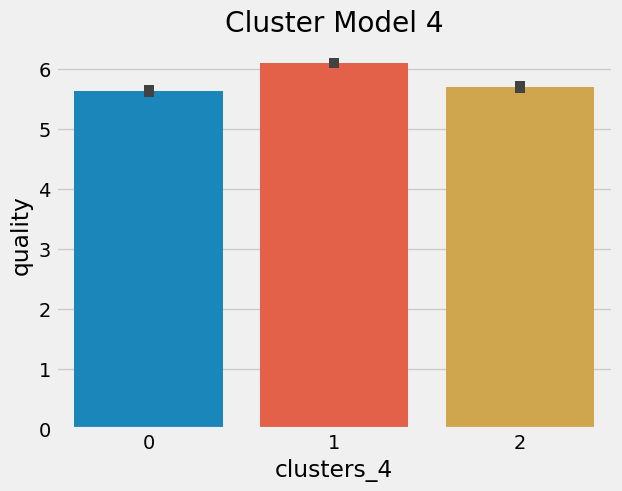

In [792]:
sns.barplot(data=train_scaled.sample(1000), y='quality', x='clusters_4')
plt.title('Cluster Model 4')

### Q4. cluster 1, 2, 3 (Anova?)

<hr style="border:2px solid black">

# **Modeling**
Plan --> Acquire --> Prepare --> Explore --> **Model** --> Deliver

In [793]:
baseline = (train.quality == 6).sum()/ len(train)
baseline

0.43661294202549916

In [794]:
# features
best_independent = ['fixed_acidity_scaled', 'volatile_acidity_scaled','density_scaled', 'alcohol_scaled']
features_1 = ['fixed_acidity_scaled', 'volatile_acidity_scaled','density_scaled', 'alcohol_scaled', 'clusters_1', 'is_red']
features_2 = ['fixed_acidity_scaled', 'volatile_acidity_scaled','density_scaled', 'alcohol_scaled', 'clusters_2', 'is_red']
features_3 = ['fixed_acidity_scaled', 'volatile_acidity_scaled','density_scaled', 'alcohol_scaled', 'clusters_3','is_red']

In [795]:
train_scaled.columns

Index(['quality', 'is_red', 'fixed_acidity_scaled', 'volatile_acidity_scaled',
       'citric_acid_scaled', 'residual_sugar_scaled', 'chlorides_scaled',
       'free_sulfur_dioxide_scaled', 'total_sulfur_dioxide_scaled',
       'density_scaled', 'ph_scaled', 'sulphates_scaled', 'alcohol_scaled',
       'clusters_1', 'clusters_2', 'clusters_3', 'clusters_4'],
      dtype='object')

In [796]:
# split into x and y for each distinct feature space

x_train_scaled = train_scaled.drop(columns=['quality'])
x_train_1 = x_train_scaled[features_1]
x_train_2 = x_train_scaled[features_2]
x_train_3 = x_train_scaled[features_3]
x_train_4 = x_train_scaled[features_4]
y_train = train.quality.to_frame()

x_val_scaled = validate_scaled.drop(columns=['quality'])
x_validate_1 = x_val_scaled[features_1]
x_validate_2 = x_val_scaled[features_2]
x_validate_3 = x_val_scaled[features_3]
x_validate_4 = x_val_scaled[features_4]
y_validate = validate.quality.to_frame()

# x_test_scaled = test_scaled.drop(columns=['quality'])
# x_test_1 = x_test_scaled[features_1]
# y_test = test.quality.to_frame()

## Decision Tree

In [797]:
scores_all = []

for x in range(1,20):

    clf = DecisionTreeClassifier(max_depth=x, random_state=666)
    clf.fit(x_train_1, y_train)
    
    # evaluate on train
    train_acc = clf.score(x_train_1, y_train)
    
    #evaluate on validate
    val_acc = clf.score(x_validate_1, y_validate)
    
    scores_all.append([x,baseline, train_acc, val_acc])
    
scores_df = pd.DataFrame(scores_all, columns=['max_depth','baseline','train_acc','val_acc'])
scores_df = pd.DataFrame(scores_all, columns=['max_depth','baseline','train_acc','val_acc'])
scores_df.sort_values(by=['val_acc'], ascending=False).head(20)

,max_depth,baseline,train_acc,val_acc
14,15,0.436613,0.862882,0.552885
13,14,0.436613,0.834255,0.552885
6,7,0.436613,0.604763,0.547115
4,5,0.436613,0.568679,0.546154
3,4,0.436613,0.557614,0.545192
16,17,0.436613,0.919894,0.544231
12,13,0.436613,0.792398,0.544231
7,8,0.436613,0.628097,0.543269
18,19,0.436613,0.958143,0.541346
10,11,0.436613,0.719509,0.540385


In [798]:
scores_all = []

for x in range(1,20):

    clf = DecisionTreeClassifier(max_depth=x, random_state=666)
    clf.fit(x_train_2, y_train)
    
    # evaluate on train
    train_acc = clf.score(x_train_2, y_train)
    
    #evaluate on validate
    val_acc = clf.score(x_validate_2, y_validate)
    
    scores_all.append([x,baseline, train_acc, val_acc])
    
scores_df = pd.DataFrame(scores_all, columns=['max_depth','baseline','train_acc','val_acc'])
scores_df = pd.DataFrame(scores_all, columns=['max_depth','baseline','train_acc','val_acc'])
scores_df.sort_values(by=['val_acc'], ascending=False).head()

,max_depth,baseline,train_acc,val_acc
11,12,0.436613,0.756315,0.557692
17,18,0.436613,0.949723,0.556731
14,15,0.436613,0.875391,0.555769
16,17,0.436613,0.931922,0.554808
13,14,0.436613,0.838586,0.553846


In [799]:
scores_all = []

for x in range(1,20):

    clf = DecisionTreeClassifier(max_depth=x, random_state=666)
    clf.fit(x_train_3, y_train)
    
    # evaluate on train
    train_acc = clf.score(x_train_3, y_train)
    
    #evaluate on validate
    val_acc = clf.score(x_validate_3, y_validate)
    
    scores_all.append([x,baseline, train_acc, val_acc])
    
scores_df = pd.DataFrame(scores_all, columns=['max_depth','baseline','train_acc','val_acc'])
scores_df = pd.DataFrame(scores_all, columns=['max_depth','baseline','train_acc','val_acc'])
scores_df.sort_values(by=['val_acc'], ascending=False).head(10)

,max_depth,baseline,train_acc,val_acc
18,19,0.436613,0.964157,0.556731
17,18,0.436613,0.952610,0.556731
11,12,0.436613,0.760404,0.555769
16,17,0.436613,0.934568,0.553846
13,14,0.436613,0.836420,0.552885
14,15,0.436613,0.875150,0.550000
15,16,0.436613,0.908347,0.547115
12,13,0.436613,0.798893,0.547115
4,5,0.436613,0.568679,0.546154
6,7,0.436613,0.610055,0.546154


> Best DT Model: Feature set 2 & max_depth= 5 \
> train: 0.5687
> validate: 0.547

## Random Forest

In [800]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)


In [801]:
rf.fit(x_train_1, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [802]:
print(rf.feature_importances_)

[0.02160534 0.2190034  0.24982003 0.43446063 0.04458816 0.03052243]


In [803]:
y_pred = rf.predict(x_train_1)

In [804]:
y_pred_proba = rf.predict_proba(x_train_1)

In [805]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(x_train_1, y_train)))


Accuracy of random forest classifier on training set: 0.54


In [806]:
print(confusion_matrix(y_train, y_pred))


[[   0    0    7   12    0    0    0]
 [   0    0   68   71    0    0    0]
 [   0    0  853  515    0    0    0]
 [   0    0  440 1375    0    0    0]
 [   0    0   38  651    1    0    0]
 [   0    0    0  123    0    0    0]
 [   0    0    0    3    0    0    0]]


In [807]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00       139
           5       0.61      0.62      0.61      1368
           6       0.50      0.76      0.60      1815
           7       1.00      0.00      0.00       690
           8       0.00      0.00      0.00       123
           9       0.00      0.00      0.00         3

    accuracy                           0.54      4157
   macro avg       0.30      0.20      0.17      4157
weighted avg       0.58      0.54      0.47      4157



In [809]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(x_validate_1, y_validate)))


Accuracy of random forest classifier on test set: 0.54


## KNN

In [851]:
for n in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(x_train_1, y_train)

    # print results
    print(f"{n} = n_neighbors on train is {knn.score(x_train_1, y_train): .2%}")
    print(f"{n} = n_neighbors on validate is        {knn.score(x_validate_1, y_validate): .2%}")

1 = n_neighbors on train is  99.90%
1 = n_neighbors on validate is         56.63%
2 = n_neighbors on train is  79.29%
2 = n_neighbors on validate is         49.71%
3 = n_neighbors on train is  74.19%
3 = n_neighbors on validate is         50.00%
4 = n_neighbors on train is  69.86%
4 = n_neighbors on validate is         50.77%
5 = n_neighbors on train is  66.90%
5 = n_neighbors on validate is         53.27%
6 = n_neighbors on train is  65.19%
6 = n_neighbors on validate is         54.23%
7 = n_neighbors on train is  63.89%
7 = n_neighbors on validate is         54.52%
8 = n_neighbors on train is  62.50%
8 = n_neighbors on validate is         53.75%
9 = n_neighbors on train is  62.42%
9 = n_neighbors on validate is         54.33%
10 = n_neighbors on train is  62.11%
10 = n_neighbors on validate is         54.90%
11 = n_neighbors on train is  62.04%
11 = n_neighbors on validate is         54.33%
12 = n_neighbors on train is  60.86%
12 = n_neighbors on validate is         53.65%
13 = n_nei

In [850]:
for n in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(x_train_2, y_train)

    # print results
    print(f"{n} = n_neighbors on train is {knn.score(x_train_2, y_train): .2%}")
    print(f"{n} = n_neighbors on validate is            {knn.score(x_validate_2, y_validate): .2%}")

1 = n_neighbors on train is  99.90%
1 = n_neighbors on validate is             57.60%
2 = n_neighbors on train is  79.05%
2 = n_neighbors on validate is             49.81%
3 = n_neighbors on train is  74.43%
3 = n_neighbors on validate is             50.96%
4 = n_neighbors on train is  69.43%
4 = n_neighbors on validate is             52.12%
5 = n_neighbors on train is  66.13%
5 = n_neighbors on validate is             54.42%
6 = n_neighbors on train is  64.54%
6 = n_neighbors on validate is             54.23%
7 = n_neighbors on train is  63.39%
7 = n_neighbors on validate is             55.10%
8 = n_neighbors on train is  62.06%
8 = n_neighbors on validate is             54.42%
9 = n_neighbors on train is  61.68%
9 = n_neighbors on validate is             54.33%
10 = n_neighbors on train is  60.86%
10 = n_neighbors on validate is             54.23%
11 = n_neighbors on train is  60.86%
11 = n_neighbors on validate is             53.85%
12 = n_neighbors on train is  60.55%
12 = n_neighb

In [845]:
for n in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(x_train_3, y_train)

    # print results
    print(f"{n} = n_neighbors on train is {knn.score(x_train_3, y_train): .2%}")
    print(f"{n} = n_neighbors on validate is        {knn.score(x_validate_3, y_validate): .2%}")

1 = n_neighbors on train is  99.90%
1 = n_neighbors on validate is         55.48%
2 = n_neighbors on train is  79.89%
2 = n_neighbors on validate is         50.38%
3 = n_neighbors on train is  75.15%
3 = n_neighbors on validate is         48.56%
4 = n_neighbors on train is  70.58%
4 = n_neighbors on validate is         51.35%
5 = n_neighbors on train is  67.45%
5 = n_neighbors on validate is         53.27%
6 = n_neighbors on train is  65.10%
6 = n_neighbors on validate is         52.60%
7 = n_neighbors on train is  64.20%
7 = n_neighbors on validate is         53.08%
8 = n_neighbors on train is  62.50%
8 = n_neighbors on validate is         55.00%
9 = n_neighbors on train is  62.45%
9 = n_neighbors on validate is         53.65%
10 = n_neighbors on train is  61.58%
10 = n_neighbors on validate is         53.85%
11 = n_neighbors on train is  61.37%
11 = n_neighbors on validate is         55.48%
12 = n_neighbors on train is  60.96%
12 = n_neighbors on validate is         55.10%
13 = n_nei

> Best KNN Model: Feature set 3; n_neighbors is 20
> Train: 58.38%
> Validate: 56.25%

In [832]:
def get_tree(X_train, X_validate, y_train, y_validate, max_depth=5):
    '''Takes in 4 positional arguments for X_train, X_validate, y_train, y_validate. Creates (max_depth=5, random_state=666) and fits DT model on train data. Returns print statement of the accuracy score for the model on train and validate.
    '''

    # create classifier object
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=666)

    #fit model on training data
    clf = clf.fit(X_train, y_train)

    # print result
    print(f"Accuracy of Decision Tree on train data is {clf.score(X_train, y_train): .2%}")
    print(f"Accuracy of Decision Tree on validate data is {clf.score(X_validate, y_validate): .2%}")

<hr style="border:2px solid black">

# **Conclusions**
